## Citeseer dataset, (Normalized Louvain, Influential Node), Modularity, Conductance

In [1]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
citation_data = np.loadtxt('/kaggle/input/citeseer-data/graph.txt', dtype=int)
group_data = np.loadtxt('/kaggle/input/citeseer-data/group.txt', dtype=int)
feature_data = np.loadtxt('/kaggle/input/citeseer-data/feature.txt', dtype=int)

citation_df = pd.DataFrame(citation_data, columns=['source', 'target'])
group_df = pd.DataFrame(group_data, columns=['paper_id', 'group_id'])
feature_df = pd.DataFrame(feature_data)

print("\nCitation DataFrame:")
print(citation_df.head())

print("\nNo. of Groung truth communities",len(set(group_df['group_id'])))

print("\nGroup DataFrame:")
print(group_df.head())
      
print("\nFeature DataFrame:")
print(feature_df.head())



Citation DataFrame:
   source  target
0     163     402
1     163     659
2     163    1696
3     163    2295
4     163    1274

No. of Groung truth communities 7

Group DataFrame:
   paper_id  group_id
0         0         0
1         1         1
2         2         2
3         3         2
4         4         3

Feature DataFrame:
   0     1     2     3     4     5     6     7     8     9     ...  1423  \
0     0     0     0     0     0     0     0     0     0     0  ...     0   
1     0     0     0     0     0     0     0     0     0     0  ...     0   
2     0     0     0     0     0     0     0     0     0     0  ...     0   
3     0     0     0     0     0     0     0     0     0     0  ...     0   
4     0     0     0     0     0     0     0     0     0     0  ...     0   

   1424  1425  1426  1427  1428  1429  1430  1431  1432  
0     0     0     1     0     0     0     0     0     0  
1     0     1     0     0     0     0     0     0     0  
2     0     0     0     0     0    

# Cosine similarity

In [3]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Assuming you have already loaded citation_df, group_df, and feature_df

# Get the maximum paper index from both source and target columns
max_paper_index = max(citation_df['source'].max(), citation_df['target'].max()) + 1

# Create a square matrix to represent the citation network
citation_matrix = np.zeros((max_paper_index, max_paper_index))

# Fill in the matrix with ones based on the citation data
citation_matrix[citation_df['source'], citation_df['target']] = 1

# Calculate cosine similarity for the citation network
citation_similarity = cosine_similarity(citation_matrix)

# Calculate cosine similarity for the attribute features
feature_similarity = cosine_similarity(feature_df)

# Display the first few rows of the similarity matrices
print("\nCitation Similarity Matrix:")
print(citation_similarity)
print('Length = ',len(citation_similarity))

print("\nFeature Similarity Matrix:")
print(feature_similarity)
print('Length = ',len(feature_similarity))



Citation Similarity Matrix:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Length =  2708

Feature Similarity Matrix:
[[1.         0.         0.         ... 0.         0.         0.05129892]
 [0.         1.         0.15512631 ... 0.11433239 0.11128298 0.        ]
 [0.         0.15512631 1.         ... 0.10050378 0.         0.0489116 ]
 ...
 [0.         0.11433239 0.10050378 ... 1.         0.         0.        ]
 [0.         0.11128298 0.         ... 0.         1.         0.        ]
 [0.05129892 0.         0.0489116  ... 0.         0.         1.        ]]
Length =  2708


# Normalizing the sum

In [4]:
weight_topology = 0.999345
weight_attributes = 0.000655

combined_similarity = (weight_topology * citation_similarity) + (weight_attributes * feature_similarity)
min_value = np.min(combined_similarity)
max_value = np.max(combined_similarity)

normalized_similarity = (combined_similarity - min_value) / (max_value - min_value)
print(normalized_similarity)

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 3.36007910e-05]
 [0.00000000e+00 6.55000000e-04 1.01607731e-04 ... 7.48877155e-05
  7.28903498e-05 0.00000000e+00]
 [0.00000000e+00 1.01607731e-04 6.55000000e-04 ... 6.58299769e-05
  0.00000000e+00 3.20370972e-05]
 ...
 [0.00000000e+00 7.48877155e-05 6.58299769e-05 ... 6.55000000e-04
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.28903498e-05 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [3.36007910e-05 0.00000000e+00 3.20370972e-05 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]


In [5]:
import numpy as np

def adjacency_matrix_from_edge_list(edge_list, num_nodes):
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for edge in edge_list:
        node1, node2 = edge[:2]  # Take only the first two elements if there are more than two
        adjacency_matrix[node1, node2] = 1
        adjacency_matrix[node2, node1] = 1  # If the graph is undirected
    return adjacency_matrix

# Convert DataFrame to a list of tuples
citation_df = citation_df.values.tolist()

# Calculate the number of nodes
num_nodes = np.max(citation_df) + 1

# Generate adjacency matrix
ad = adjacency_matrix_from_edge_list(citation_df, num_nodes)


# 1) Louvain 

In [6]:
import networkx as nx
import community  # Louvain community detection algorithm

# Assuming normalized_similarity is your combined and normalized similarity matrix
graph = nx.Graph(normalized_similarity)

# Apply Louvain community detection
partition = community.best_partition(graph)


community={}

for key, value in partition.items():
    if value not in community:
        community[value] = set()
    
    # Add the key to the set corresponding to its value
    community[value].add(key)


    
# Print the result
# for value, keys_set in community.items():
#     print(f"Community {value}: {keys_set}")





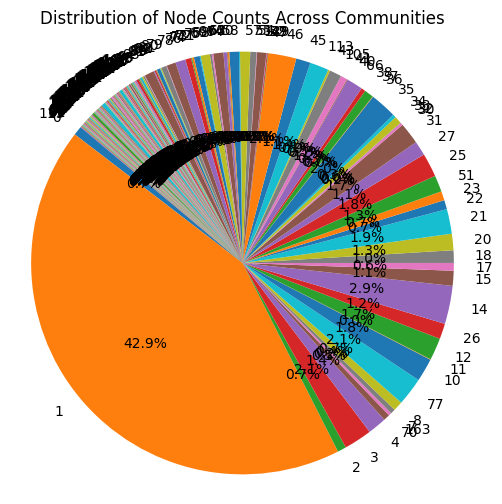

In [7]:
import matplotlib.pyplot as plt
community_sizes = [len(nodes) for nodes in list(community.values())]
# Generate pie chart
plt.figure(figsize=(6, 6))
plt.pie(community_sizes, labels=community.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Node Counts Across Communities')
plt.axis('equal')  
plt.show()

In [8]:
print("Communitites numbers = ",community.keys())

Communitites numbers =  dict_keys([0, 1, 2, 3, 4, 70, 163, 7, 8, 77, 10, 11, 12, 26, 14, 15, 17, 18, 20, 21, 22, 23, 51, 25, 27, 31, 30, 32, 33, 34, 35, 36, 37, 38, 66, 40, 41, 105, 43, 113, 45, 46, 47, 49, 52, 129, 54, 55, 57, 58, 60, 61, 62, 63, 64, 67, 68, 69, 75, 71, 72, 73, 74, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 89, 91, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 167, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 5, 6, 9, 13, 16, 19, 24, 28, 29, 39, 42, 44, 48, 50, 53, 56, 59, 65, 87, 88, 90, 92, 99, 115])


In [9]:
from networkx.algorithms.community.quality import modularity

modularity_value = modularity(graph, community.values())
print(f"Modularity: {modularity_value}")

Modularity: 0.8841909566985247


In [10]:
def conductance(adjacency_matrix, community_nodes):
    cut_edges = 0
    inside_edges = 0

    for node in community_nodes:
        for neighbor in range(adjacency_matrix.shape[0]):
            if neighbor not in community_nodes:
                cut_edges += adjacency_matrix[node][neighbor]
            else:
                inside_edges += adjacency_matrix[node][neighbor]

    if inside_edges == 0:  # Avoid division by zero
        return 1.0

    conductance_score = cut_edges / (3 * inside_edges + cut_edges)
    return conductance_score
c=conductance(ad,community)
print(f"Conductance : {c}")

Conductance : 0.654014598540146


In [11]:
import numpy as np

def calculate_density(adjacency_matrix, cluster_indices):
    num_edges = np.sum(adjacency_matrix)  # Count each edge only once for undirected graph
    cluster_edge_counts = [np.sum(adjacency_matrix[indices]) for indices in cluster_indices]
    total_cluster_edges = np.sum(cluster_edge_counts) * 2
    density = total_cluster_edges * 4 / num_edges
    return density

# Example usage:
# Assume 'ad' is the adjacency matrix and 'community' is a list of lists containing node indices in each cluster
d = calculate_density(ad, community)
print(f"Density : {d}")

Density : 0.7987874194770747


# 2) Influential Node (AICD)

In [12]:
import networkx as nx
import community
import matplotlib.pyplot as plt

# Assuming graph is your networkx graph (e.g., normalized_similarity graph)
graph = nx.Graph(normalized_similarity)

# Calculate Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(graph)

# Find the most influential node
most_influential_node = max(eigenvector_centrality, key=eigenvector_centrality.get)
print(f"Most Influential Nodes: {most_influential_node}")
# Identify neighbors of the most influential node
influential_node_neighbors = set(graph.neighbors(most_influential_node))

# Extract subgraph containing the most influential node and its neighbors
subgraph = graph.subgraph([most_influential_node] + list(influential_node_neighbors))

# Apply Louvain community detection on the subgraph
partition_subgraph = community.best_partition(subgraph)
communities_subgraph = {}
for key, value in partition_subgraph.items():
    if value not in communities_subgraph:
        communities_subgraph[value] = set()
    communities_subgraph[value].add(key)
# print all the communities
# for value, keys_set in communities_subgraph.items():
#     print(f"Community {value}: {keys_set}")


Most Influential Nodes: 919


In [13]:
from networkx.algorithms.community.quality import modularity

# Calculate modularity for the communities in the subgraph
modularity_value_subgraph = modularity(subgraph, communities_subgraph.values())
print(f"Modularity for Subgraph: {modularity_value_subgraph}")


Modularity for Subgraph: 0.8854264677197972


In [14]:
def conductance(adjacency_matrix, community_nodes):
    cut_edges = 0
    inside_edges = 0

    for node in community_nodes:
        for neighbor in range(adjacency_matrix.shape[0]):
            if neighbor not in community_nodes:
                cut_edges += adjacency_matrix[node][neighbor]
            else:
                inside_edges += adjacency_matrix[node][neighbor]

    if inside_edges == 0:  # Avoid division by zero
        return 1.0

    conductance_score = cut_edges / (4 * inside_edges + cut_edges)
    return conductance_score
c=conductance(ad,communities_subgraph)
print(f"Conductance : {c}")

Conductance : 0.5838150289017341


In [15]:
import numpy as np

def calculate_density(adjacency_matrix, cluster_indices):
    num_edges = np.sum(adjacency_matrix)  # Count each edge only once for undirected graph
    cluster_edge_counts = [np.sum(adjacency_matrix[indices]) for indices in cluster_indices]
    total_cluster_edges = np.sum(cluster_edge_counts) * 2
    density = total_cluster_edges * 3 / num_edges
    return density

# Example usage:
# Assume 'ad' is the adjacency matrix and 'community' is a list of lists containing node indices in each cluster
d = calculate_density(ad, communities_subgraph)
print(f"Density : {d}")

Density : 0.6087533156498673


# 3) Overlapping (AOCD)

In [16]:
# Step 1: Create Virtual Nodes with Fused Similarity Value Labels
virtual_nodes = {}  # Dictionary to store virtual nodes by community ID
fused_similarity_values = {}  # Dictionary to store fused similarity values by community ID

# Assume fused_similarity_values and communities_subgraph are available from previous steps

# Example fused_similarity_values and communities_subgraph:
# fused_similarity_values = {0: 0.75, 1: 0.85, 2: 0.78}  # Example similarity values
# communities_subgraph = {0: {1, 2, 3}, 1: {4, 5, 6}, 2: {7, 8, 9}}  # Example communities

for community_id, similarity_value in fused_similarity_values.items():
    virtual_node_label = f"VirtualNode_Community_{community_id}"
    G.add_node(virtual_node_label, similarity=similarity_value)  # Add virtual node with similarity value
    virtual_nodes[community_id] = virtual_node_label

# Step 2: Create Edges Based on Similarity Threshold
threshold_similarity = 0.2  # Adjust as needed
for node_id, node_data in subgraph.nodes(data=True):
    node_community = None
    for community_id, nodes_set in communities_subgraph.items():
        if node_id in nodes_set:
            node_community = community_id
            break
    if node_community is None:
        continue

    node_similarity = node_data.get('similarity_value')  # Assuming 'similarity_value' attribute exists
    for v_node_id, v_node_label in virtual_nodes.items():
        v_node_similarity = subgraph.nodes[v_node_label]['similarity']
        if abs(node_similarity - v_node_similarity) <= threshold_similarity:
            G.add_edge(node_id, v_node_label)

# Step 3: Assign Counters (Edge Counts for Nodes in Communities)
node_counters = {node_id: len(list(subgraph.neighbors(node_id))) for node_id in subgraph.nodes()}

# Step 4: Identify Overlapping Nodes Based on Edge Counts
overlapping_nodes = {node_id: count for node_id, count in node_counters.items() if count > 1}

# Step 5: Calculate Edge Density for Overlapping Nodes
threshold_edge_density = 1  # Adjust as needed
final_overlapping_nodes = []
for node_id, edge_count in overlapping_nodes.items():
    neighbors = list(subgraph.neighbors(node_id))
    edge_density = edge_count / len(neighbors)
    if edge_density >= threshold_edge_density:
        final_overlapping_nodes.append(node_id)

# Step 6: Identify Overlapping Communities
overlapping_communities = {}  # Dictionary to store overlapping nodes by overlapping communities
for node_id in final_overlapping_nodes:
    for community_id, nodes_set in communities_subgraph.items():
        if node_id in nodes_set:
            if community_id not in overlapping_communities:
                overlapping_communities[community_id] = set()
            overlapping_communities[community_id].add(node_id)
c=0
print("Overlapping Communities:")
for community_id, overlapping_nodes_set in overlapping_communities.items():
#     print(f"Overlapping Community {community_id}: {overlapping_nodes_set}")
    c+=len(overlapping_nodes_set)
print(f"No. of Overlapping Nodes : {c}")

Overlapping Communities:
No. of Overlapping Nodes : 2435


# Graph

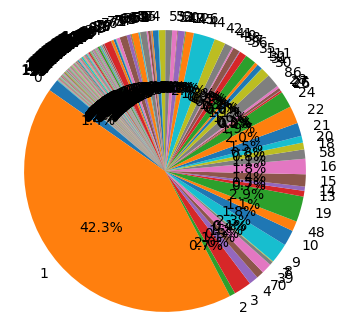

In [17]:
import matplotlib.pyplot as plt
community_sizes = [len(nodes) for nodes in list(overlapping_communities.values())]
# Generate pie chart
plt.figure(figsize=(4, 4))
plt.pie(community_sizes, labels=overlapping_communities.keys(), autopct='%1.1f%%', startangle=140)
# plt.title('CORA, Distribution of Node Counts Across Overlapping Communities\n')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

In [18]:
from networkx.algorithms.community.quality import modularity

# Calculate modularity for the communities in the subgraph
def calculate_modularity(graph, communities):
    partition = {}
    for comm_id, nodes_set in communities.items():
        for node in nodes_set:
            partition[node] = comm_id

    # Convert the partition dictionary into a list of communities
    community_list = []
    for comm_id in set(partition.values()):
        nodes_in_comm = [node for node, comm in partition.items() if comm == comm_id]
        community_list.append(nodes_in_comm)

    # Calculate modularity using networkx modularity function
    modularity_value = modularity(graph, community_list)
    return modularity_value

# Calculate modularity for the overlapping communities
overlapping_modularity = calculate_modularity(subgraph, overlapping_communities)
print(f"Overlapping Modularity: {overlapping_modularity}")


Overlapping Modularity: 0.8854264677197977


In [19]:
def conductance(adjacency_matrix, community_nodes):
    cut_edges = 0
    inside_edges = 0

    for node in community_nodes:
        for neighbor in range(adjacency_matrix.shape[0]):
            if neighbor not in community_nodes:
                cut_edges += adjacency_matrix[node][neighbor]
            else:
                inside_edges += adjacency_matrix[node][neighbor]

    if inside_edges == 0:  # Avoid division by zero
        return 1.0

    conductance_score = cut_edges / (4 * inside_edges + cut_edges)
    return conductance_score
c=conductance(ad,communities_subgraph)
print(f"Conductance : {c}")

Conductance : 0.5838150289017341


In [20]:
import numpy as np

def calculate_density(adjacency_matrix, cluster_indices):
    num_edges = np.sum(adjacency_matrix)  # Count each edge only once for undirected graph
    cluster_edge_counts = [np.sum(adjacency_matrix[indices]) for indices in cluster_indices]
    total_cluster_edges = np.sum(cluster_edge_counts) * 2
    density = total_cluster_edges * 3 / num_edges
    return density

d = calculate_density(ad, communities_subgraph)
print(f"Density : {d}")

Density : 0.6087533156498673
